# Vehicle Re-identification using Transformer and Contrastive Learning

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os

from dataset import VehicleReIDDataset
from vit import ViTEncoder
from loss import TripletLoss

In [2]:
# DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print(DEVICE)

cuda


### Utility Functions

In [3]:
def get_hard_triplets(embeddings, labels):
    '''
    Selects hard positives and negatives based on Euclidean distances.
    '''
    labels = labels.cpu().numpy()
    pairwise_distances = torch.cdist(embeddings, embeddings)  # Compute pairwise distances

    hard_triplets = []
    for i in range(len(labels)):
        anchor_idx = i
        anchor_label = labels[i]

        # Hard positive: Closest with same label
        positive_indices = np.where(labels == anchor_label)[0]
        positive_indices = positive_indices[positive_indices != i]  # Exclude self
        if len(positive_indices) == 0:
            continue
        positive_idx = positive_indices[torch.argmin(pairwise_distances[i, positive_indices])]

        # Hard negative: Furthest with different label
        negative_indices = np.where(labels != anchor_label)[0]
        negative_idx = negative_indices[torch.argmax(pairwise_distances[i, negative_indices])]

        hard_triplets.append((anchor_idx, positive_idx, negative_idx))

    return hard_triplets

In [4]:
def extract_embeddings(model, dataloader, device):
    '''
    Extracts embeddings for images in the dataset.
    '''
    model.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            embeddings = model(images)
            all_embeddings.append(embeddings.cpu())
            all_labels.extend(labels.numpy())

    return torch.cat(all_embeddings), np.array(all_labels)

def retrieve_top_k(embedding, dataset_embeddings, dataset_labels, k=5):
    '''
    Retrieve top-k similar images using Euclidean distance.
    '''
    distances = torch.cdist(embedding.unsqueeze(0), dataset_embeddings)
    top_k_indices = torch.argsort(distances, dim=1)[0][:k]
    return dataset_labels[top_k_indices]

In [5]:
# initilaizing model
model = ViTEncoder(
    embed_dim=256,
    depth=4,
    n_heads=8,
    out_dim=512,
)

# defining transformations
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Training

In [6]:
def train(model, dataloader, optimizer, loss_fn, device, epochs=10):
    model.train()
    train_loss_hist = []
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            # Extract embeddings
            embeddings = model(images)

            # Hard triplet selection
            triplets = get_hard_triplets(embeddings, labels)
            if len(triplets) == 0:
                continue

            anchor, positive, negative = zip(*triplets)
            anchor = torch.stack([embeddings[i] for i in anchor])
            positive = torch.stack([embeddings[i] for i in positive])
            negative = torch.stack([embeddings[i] for i in negative])

            # Compute loss
            loss = loss_fn(anchor, positive, negative)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(dataloader)
        train_loss_hist.append(epoch_loss)
        print(f'Epoch {epoch+1:3}/{epochs:3} | Loss: {epoch_loss:.4f}')
    return train_loss_hist

In [7]:
# Initialize dataset and dataloader
vric_dataset = VehicleReIDDataset(root_dir='data/VRIC_dataset/train_images', labels_file='data/VRIC_dataset/vric_train.txt', name='VRIC', transform=transform)
train_loader = DataLoader(vric_dataset, batch_size=100, shuffle=True)

model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = TripletLoss(margin=0.3)

In [8]:
# Train model
train_loss_hist = train(model, train_loader, optimizer, loss_fn, DEVICE, epochs=10)

100%|██████████| 549/549 [06:40<00:00,  1.37it/s]


Epoch   1/ 10 | Loss: 0.0019


100%|██████████| 549/549 [06:48<00:00,  1.35it/s]


Epoch   2/ 10 | Loss: 0.0026


100%|██████████| 549/549 [06:43<00:00,  1.36it/s]


Epoch   3/ 10 | Loss: 0.0017


100%|██████████| 549/549 [06:52<00:00,  1.33it/s]


Epoch   4/ 10 | Loss: 0.0014


100%|██████████| 549/549 [06:49<00:00,  1.34it/s]


Epoch   5/ 10 | Loss: 0.0022


100%|██████████| 549/549 [06:43<00:00,  1.36it/s]


Epoch   6/ 10 | Loss: 0.0029


100%|██████████| 549/549 [06:46<00:00,  1.35it/s]


Epoch   7/ 10 | Loss: 0.0013


100%|██████████| 549/549 [06:49<00:00,  1.34it/s]


Epoch   8/ 10 | Loss: 0.0016


100%|██████████| 549/549 [06:50<00:00,  1.34it/s]


Epoch   9/ 10 | Loss: 0.0018


100%|██████████| 549/549 [06:52<00:00,  1.33it/s]

Epoch  10/ 10 | Loss: 0.0024


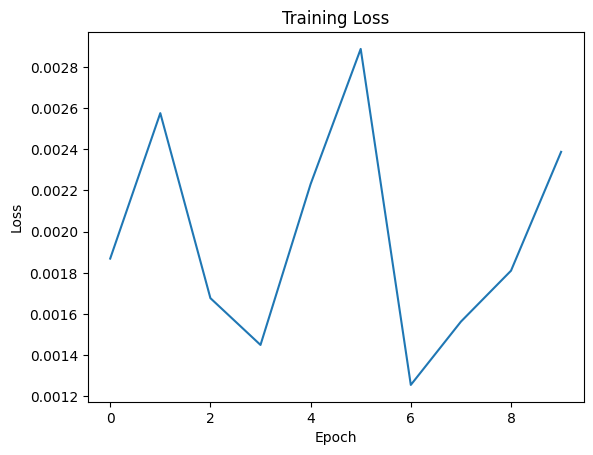

In [9]:
# Plot training loss
plt.figure()
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss_hist)
plt.show()

In [10]:
# Saving model
torch.save(model.state_dict(), 'trained_models/model_10.pth')

### Inference

In [11]:
model.load_state_dict(torch.load('trained_models/model_10.pth', map_location=DEVICE))
model.to(DEVICE)

model.eval()

ViTEncoder(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-3): 4 x Block(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (projection_head): Sequential(
    (0): Linear(in_features=256,

In [12]:
def infer(model, image_path, device=DEVICE, transform=transform):
    '''
    Extracts embeddings for a single image.
    '''
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(image)
    return embedding.cpu().numpy().flatten()

trial_image_path = './data/VeRi_CARLA_dataset/image_gallery/20220710050038_0_44.jpg'
infer(model, trial_image_path)

array([ 0.02716406, -0.02964275,  0.06454185, -0.06388696, -0.03227132,
        0.04492643,  0.03766097,  0.02965811, -0.05603904, -0.01164888,
        0.06753622,  0.03178975,  0.0091524 , -0.03570563, -0.0626044 ,
        0.03144142,  0.05684159, -0.02544619,  0.0222094 ,  0.03124323,
       -0.00402171, -0.03557015,  0.0646847 ,  0.03573905, -0.03508517,
        0.06106313, -0.03236848,  0.0459704 , -0.03254233,  0.07328027,
        0.04205935, -0.06834046, -0.01287706, -0.07506882,  0.01518621,
       -0.05812644, -0.06122102,  0.10551023, -0.00649777,  0.03834106,
        0.0278732 , -0.01026488, -0.03497251, -0.0103535 , -0.01390993,
        0.05046586, -0.06015466, -0.00927675,  0.03851607,  0.02868574,
       -0.07977004,  0.02313342,  0.03546132,  0.06593459, -0.0255855 ,
       -0.02590386,  0.02517218, -0.04567979, -0.06782153,  0.06014811,
       -0.07241833,  0.02705109,  0.06875024, -0.02359903,  0.06211995,
       -0.05636566,  0.04335517,  0.04973178, -0.04827351, -0.04

### Performance Analysis

In [13]:
model.load_state_dict(torch.load('trained_models/model.pth', map_location=DEVICE))
model.to(DEVICE)

model.eval()

ViTEncoder(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-3): 4 x Block(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (projection_head): Sequential(
    (0): Linear(in_features=256,

In [14]:
# query_dataset = VehicleReIDDataset(root_dir='data/VeRi_CARLA_dataset/image_query', name='VeRi_CARLA', transform=transform)
# gallery_dataset = VehicleReIDDataset(root_dir='data/VeRi_CARLA_dataset/image_gallery', name='VeRi_CARLA', transform=transform)

vric_query = VehicleReIDDataset(root_dir='data/VRIC_dataset/probe_images', labels_file='data/VRIC_dataset/vric_probe.txt', name='VRIC', transform=transform)
vric_gallery = VehicleReIDDataset(root_dir='data/VRIC_dataset/gallery_images', labels_file='data/VRIC_dataset/vric_gallery.txt', name='VRIC', transform=transform)

query_loader = DataLoader(vric_query, batch_size=1, shuffle=False)
gallery_loader = DataLoader(vric_gallery, batch_size=1, shuffle=False)

query_embeddings, query_labels = extract_embeddings(model, query_loader, DEVICE)
gallery_embeddings, gallery_labels = extract_embeddings(model, gallery_loader, DEVICE)

In [15]:
# Compute cosine similarity
similarity = cosine_similarity(query_embeddings, gallery_embeddings)

Rank-1 Accuracy: 1.96%
Rank-5 Accuracy: 5.34%
Rank-10 Accuracy: 8.36%


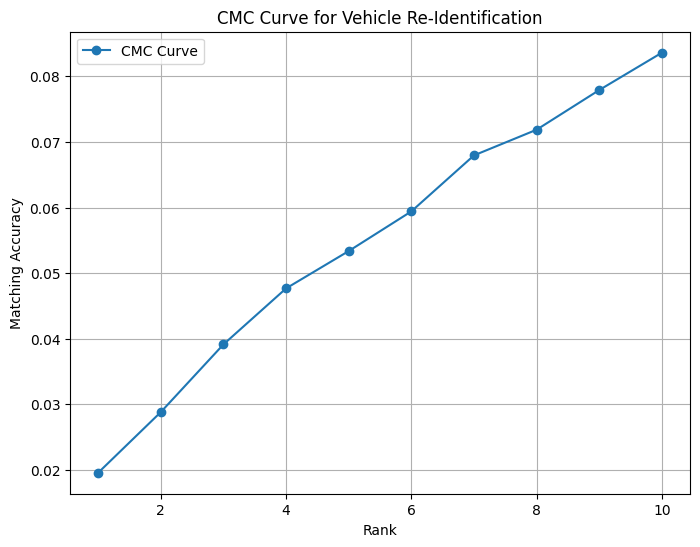

In [16]:
def compute_cmc(similarity_matrix, query_ids, gallery_ids, max_rank=10):
    """Computes CMC Curve & Rank-N Accuracy"""
    num_queries = len(query_ids)
    cmc_curve = np.zeros(max_rank)

    for i in range(num_queries):
        # Sort gallery images by similarity score
        sorted_indices = np.argsort(similarity_matrix[i])[::-1]

        # Get ranked list of predicted IDs
        ranked_vehicle_ids = gallery_ids[sorted_indices]

        # Find rank of the first correct match
        correct_match_ranks = np.where(ranked_vehicle_ids == query_ids[i])[0]

        if len(correct_match_ranks) > 0:
            first_correct_rank = correct_match_ranks[0]
            cmc_curve[first_correct_rank:] += 1  # Increment all ranks ≥ first match

    cmc_curve /= num_queries  # Normalize

    # Rank-N Metrics
    rank_1 = cmc_curve[0] * 100
    rank_5 = cmc_curve[4] * 100 if max_rank >= 5 else None
    rank_10 = cmc_curve[9] * 100 if max_rank >= 10 else None

    return cmc_curve, rank_1, rank_5, rank_10

cmc_curve, rank_1, rank_5, rank_10 = compute_cmc(similarity, query_labels, gallery_labels)

print(f"Rank-1 Accuracy: {rank_1:.2f}%")
print(f"Rank-5 Accuracy: {rank_5:.2f}%" if rank_5 else "")
print(f"Rank-10 Accuracy: {rank_10:.2f}%" if rank_10 else "")

ranks = np.arange(1, len(cmc_curve) + 1)
plt.figure(figsize=(8, 6))
plt.plot(ranks, cmc_curve, marker="o", linestyle="-", label="CMC Curve")
plt.xlabel("Rank")
plt.ylabel("Matching Accuracy")
plt.title("CMC Curve for Vehicle Re-Identification")
plt.legend()
plt.grid()
plt.show()

In [17]:
def compute_map(similarity_matrix, query_ids, gallery_ids):
    """Computes mean Average Precision (mAP)"""
    num_queries = len(query_ids)
    average_precisions = []

    for i in range(num_queries):
        # Sort gallery images by similarity score
        sorted_indices = np.argsort(similarity_matrix[i])[::-1]

        # Get binary relevance vector (1 if correct, 0 otherwise)
        relevance = (gallery_ids[sorted_indices] == query_ids[i]).astype(int)

        # Compute Average Precision (AP)
        if relevance.sum() > 0:
            ap = average_precision_score(relevance, similarity_matrix[i, sorted_indices])
            average_precisions.append(ap)

    return np.mean(average_precisions)

map_score = compute_map(similarity, query_labels, gallery_labels)
print(f'Mean Average Precision (mAP): {map_score * 100:.2f}%')

Mean Average Precision (mAP): 4.37%
